In [1]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torchvision import datasets, transforms
import torch.cuda
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.nn import TripletMarginLoss
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
import cv2
from torch.utils.data import DataLoader
warnings.filterwarnings('ignore')

In [3]:

# Define the face detection function
def detect_and_crop_face(image):
    # Load the pre-trained face detection model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert image to grayscale
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        # No faces detected, return original image
        return image

    # Get the largest detected face
    (x, y, w, h) = max(faces, key=lambda face: face[2] * face[3])

    # Crop the face region from the image
    cropped_face = image.crop((x, y, x + w, y + h))

    return cropped_face

# Define transforms for preprocessing during training
mean = [0.5]
std = [0.5]

train_transform = transforms.Compose([
    # Custom face detection and cropping
    transforms.Lambda(lambda img: detect_and_crop_face(img)),
    transforms.Resize((224, 224)),            # Resize images to 224x224
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally
    transforms.RandomRotation(10),            # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),                    # Convert images to PyTorch tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize
])

# Define transform for preprocessing during testing
test_transform = transforms.Compose([
    # Custom face detection and cropping
    transforms.Lambda(lambda img: detect_and_crop_face(img)),
    transforms.Resize((224, 224)),            # Resize images to 224x224
    transforms.ToTensor(),                    # Convert images to PyTorch tensors
    transforms.Normalize(mean=mean, std=std)  # Normalize
])

# Load the dataset using ImageFolder
train_dataset = datasets.ImageFolder(root='./data/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='./data/val', transform=test_transform)

# Define batch size
batch_size = 32

# Create DataLoader for train and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


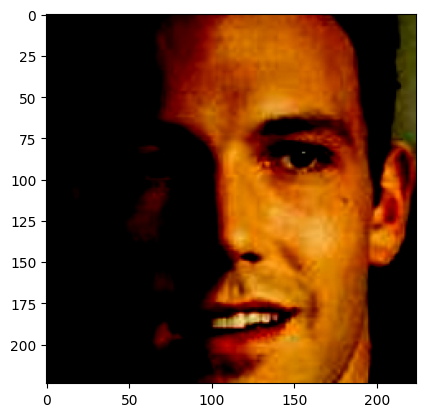

In [4]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = dataiter._next_data()

image = images[0].squeeze()  
image = image.numpy().transpose((1, 2, 0)) 

plt.imshow(image)
plt.show()


In [18]:
def calculate_accuracy(model, dataloader, device):
    correct = 0
    total = 0

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()



In [19]:
def plot_loss(loss_list):
    plt.figure(figsize=(8, 6))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(loss_list)
    plt.show()

def plot_loss_multi(loss_list, loss):
    plt.figure(figsize=(8, 6))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.xlim(10,40)
    plt.plot(loss_list, color='g', label='train') 
    plt.plot(loss, color='r', label='test') 
    plt.show()

In [21]:
class_labels = ['ben', 'john', 'jerry', 'madonna', 'mindy']

def predict(model, image):


  def detect_and_crop_face(image):
    # Load the pre-trained face detection model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert image to grayscale
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        # No faces detected, return original image
        return image

    # Get the largest detected face
    (x, y, w, h) = max(faces, key=lambda face: face[2] * face[3])

    # Crop the face region from the image
    cropped_face = image.crop((x, y, x + w, y + h))

    return cropped_face
  
  # Preprocessing steps (same as your test_transform)
  preprocess = transforms.Compose([
    transforms.Lambda(lambda img: detect_and_crop_face(img)),
    transforms.Resize((224, 224)),            # Resize images to 224x224
    transforms.ToTensor(),                    # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
  ])
  # Convert image to RGB and preprocess
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # image = Image.fromarray(image)
  image_tensor = preprocess(image)

  # Add an extra dimension for batch size (assumes single image inference)
  image_tensor = image_tensor.unsqueeze(0)

  # Set model to evaluation mode
  # model.eval()

  # Perform inference
  with torch.no_grad():
      image_tensor = image_tensor.to(device)
      output = model(image_tensor)

  # Get predicted class with highest probability (assuming classification task)
  _, predicted_class = torch.max(output.data, 1)

  # Replace 'class_labels' with your actual class labels
    # Example class labels
  predicted_label = class_labels[predicted_class.item()]

  return predicted_label

In [20]:
resnet = models.resnet18(pretrained=True)
# resnet = models.resnet18(pretrained=True)


In [22]:
resnet.fc = nn.Linear(in_features=512, out_features=5, bias=True)
# resnet.fc = nn.Sequential(
#   nn.Dropout(p=0.3, inplace=False),
#   nn.Linear(in_features=512, out_features=256, bias=True),
#   nn.ReLU(inplace=True),
#   nn.Dropout(p=0.3, inplace=False),
#   nn.Linear(in_features=256, out_features=128, bias=True),
#   # nn.ReLU(inplace=True),
#   # nn.Linear(in_features=128, out_features=64, bias=True),
#   # nn.ReLU(inplace=True),
#   nn.Linear(in_features=128, out_features=5, bias=True),
#   nn.ReLU(inplace=True),
# )

In [24]:
resnet = resnet.to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
# criterion = TripletMarginLoss()
optimizer = optim.Adam(resnet.parameters())

In [26]:
resnet_loss = []
resnet_loss_test = []
epochs = 35
margin = 0.5
num_classes = 5
embedding_size = 512 ## maybe resnet.fc.in_features or 64 or 128
# loss_fn = losses.ArcFaceLoss(margin=margin, num_classes=num_classes, embedding_size=embedding_size)
steps = len(train_loader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet(images)
        loss = criterion(outputs, labels)
        
        # loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        resnet_loss.append(loss.item())
    print (f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Test loop (after each epoch)
    with torch.no_grad():  # disable gradient calculation for efficiency
        for i, (images, labels) in enumerate(test_loader):
            
            images = images.to(device)
            labels = labels.to(device)

            test_outputs = resnet(images)
            test_loss = criterion(test_outputs, labels)
            # test_loss = loss_fn(test_outputs, labels)
            
            resnet_loss_test.append(test_loss.item())
            
    print(f'Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss.item():.4f}')

Epoch [1/35], Loss: 0.7041
Epoch [1/35], Test Loss: 0.3476
Epoch [2/35], Loss: 0.5263
Epoch [2/35], Test Loss: 0.4562
Epoch [3/35], Loss: 0.2780
Epoch [3/35], Test Loss: 0.3427
Epoch [4/35], Loss: 0.2447
Epoch [4/35], Test Loss: 0.2475
Epoch [5/35], Loss: 0.1243
Epoch [5/35], Test Loss: 0.1231
Epoch [6/35], Loss: 0.0993
Epoch [6/35], Test Loss: 0.1712
Epoch [7/35], Loss: 0.1937
Epoch [7/35], Test Loss: 0.2134
Epoch [8/35], Loss: 0.0352
Epoch [8/35], Test Loss: 0.3867
Epoch [9/35], Loss: 0.0991
Epoch [9/35], Test Loss: 0.1324
Epoch [10/35], Loss: 0.0126
Epoch [10/35], Test Loss: 0.1893
Epoch [11/35], Loss: 0.0895
Epoch [11/35], Test Loss: 0.3728
Epoch [12/35], Loss: 0.1050
Epoch [12/35], Test Loss: 0.5369
Epoch [13/35], Loss: 0.0684
Epoch [13/35], Test Loss: 0.6443
Epoch [14/35], Loss: 0.1277
Epoch [14/35], Test Loss: 0.5423
Epoch [15/35], Loss: 0.0056
Epoch [15/35], Test Loss: 0.5340
Epoch [16/35], Loss: 0.2349
Epoch [16/35], Test Loss: 0.1543
Epoch [17/35], Loss: 0.2482
Epoch [17/35],

In [6]:
resnet_acc = calculate_accuracy(resnet, train_loader, device)
print("Accuracy on train set: {:.2f}%".format(resnet_acc * 100))

In [28]:
resnet_acc = calculate_accuracy(resnet, test_loader, device)
print("Accuracy on test set: {:.2f}%".format(resnet_acc * 100))

Accuracy on test set: 96.00%


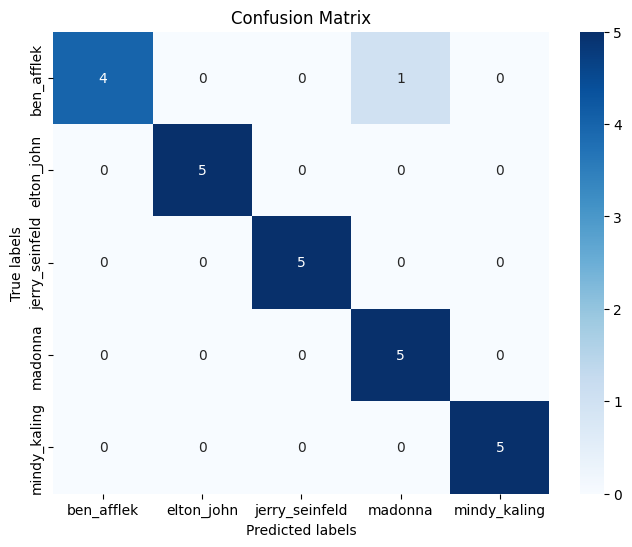

In [29]:
class_names = train_dataset.classes
plot_confusion_matrix(resnet, test_loader, class_names, device)

In [30]:
# resnet_loss_test = []
# epochs = 30
# steps = len(test_loader)
# for epoch in range(epochs):
#     for i, (images, labels) in enumerate(test_loader):
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = resnet(images)
#         loss = criterion(outputs, labels)

#         # optimizer.zero_grad()
#         # loss.backward()
#         # optimizer.step()

#         resnet_loss_test.append(loss.item())
#     print (f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

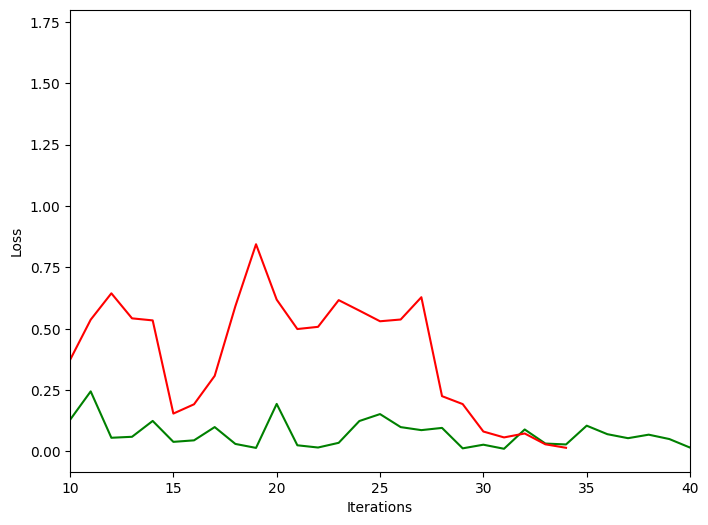

In [31]:
plot_loss_multi(resnet_loss, resnet_loss_test)

In [32]:
# print(resnet)

In [40]:
torch.save(resnet.state_dict(), '512x5-98-96.pth')

In [34]:
def capture_and_predict(model):
  """
  Captures an image from webcam, performs preprocessing, and predicts using the model.

  Args:
      model (torch.nn.Module): Trained model for inference.
      class_labels (list): List of class labels corresponding to model output.

  Returns:
      str: Predicted label or None if image capture fails.
  """
  # Initialize video capture object
  cap = cv2.VideoCapture(0)

  # Check if camera opened successfully
  if not cap.isOpened():
      print("Error opening camera!")
      return None

  while True:
      # Capture frame-by-frame
      ret, frame = cap.read()

      # Check if frame captured successfully
      if not ret:
          print("Error capturing frame!")
          break

      # Display the resulting frame
      cv2.imshow('Capture Image (Press q to capture)', frame)

      # Capture image on 'q' key press
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break

  # Release capture object
  cap.release()
  cv2.destroyAllWindows()

  # Check if image captured
  if frame is None:
      return None

  image = Image.fromarray(frame)

  # Predict on captured image
  predicted_label = predict(model, image)
  print(f"Predicted Label: {predicted_label}")

  return predicted_label


In [35]:
# captured_label = capture_and_predict(resnet)

# if captured_label is not None:
#   print("Prediction complete!")
# else:
#   print("Failed to capture image or perform prediction.")


In [36]:
def load_and_predict(resnet, image_path):
  """
  Loads an image from file, performs preprocessing, and predicts using the model.

  Args:
      resnet (torch.nn.Module): Trained model for inference.
      image_path (str): Path to image file.

  Returns:
      str: Predicted label or None if image loading fails.
  """
  # Load image from file
  image = Image.open(image_path)

  # Predict on loaded image
  predicted_label = predict(resnet, image)
  print(f"Predicted Label: {predicted_label}")

  return predicted_label

In [7]:
image_path = '6.jpg'
predicted_label = load_and_predict(resnet, image_path)

if predicted_label is not None:
    print("Prediction complete!")
else:   
    print("Failed to load image or perform prediction.")

NameError: name 'load_and_predict' is not defined